# Chinook Sample DB - SQLite

In [124]:
import sqlite3
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
%matplotlib inline

db = 'chinook.db'

# Create function to return pd.Dataframe from SQL query string

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

# List all tables and views in the DB

tables = run_query('''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
               ''')

tables

,name,type
0,albums,table
1,sqlite_sequence,table
2,artists,table
3,customers,table
4,employees,table
5,genres,table
6,invoices,table
7,invoice_items,table
8,media_types,table
9,playlists,table


In [60]:
# Top 25 Selling Audio Tracks by Revenue

top_tracks = '''
SELECT t.name track_name,
       ar.name artist_name,
       SUM(ii.unitPrice * ii.quantity) total_revenue
FROM artists ar
JOIN albums al ON al.artistId = ar.artistId
JOIN tracks t ON t.albumId = al.albumId
JOIN invoice_items ii ON ii.trackId = t.trackId
JOIN media_types mt ON mt.mediaTypeId = t.mediaTypeId
WHERE mt.name IN (SELECT DISTINCT name
                  FROM media_types
                  WHERE name LIKE "%audio%")
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 25;
'''
run_query(top_tracks)

,track_name,artist_name,total_revenue
0,The Trooper,Iron Maiden,4.95
1,Eruption,Van Halen,3.96
2,Hallowed Be Thy Name,Iron Maiden,3.96
3,Sure Know Something,Kiss,3.96
4,The Number Of The Beast,Iron Maiden,3.96
5,2 Minutes To Midnight,Iron Maiden,2.97
6,Blood Brothers,Iron Maiden,2.97
7,Can I Play With Madness,Iron Maiden,2.97
8,Dazed and Confused,Led Zeppelin,2.97
9,Flying High Again,Ozzy Osbourne,2.97


In [57]:
# Top 20 Selling Albums by number of tracks sold

top_albums = '''
WITH ta AS (SELECT t.trackId,
                   al.title album_title,
                   ar.name artist_name,
                   mt.name media_type
            FROM tracks t
            JOIN media_types mt ON mt.mediaTypeID = t.mediaTypeID
            JOIN albums al ON al.albumId = t.albumId
            JOIN artists ar ON ar.artistId = al.artistId
            ),
      
      mt AS (SELECT DISTINCT name
             FROM media_types
             WHERE name LIKE "%audio%")

SELECT
    ta.album_title album,
    ta.artist_name artist,
    ta.media_type media_type,
    SUM(ii.quantity) tracks_purchased
FROM invoice_items ii
JOIN ta
ON ta.trackId = ii.trackId
WHERE ta.media_type IN mt
GROUP BY 1, 2, 3
ORDER BY 4 DESC 
LIMIT 20;
'''

run_query(top_albums)

,album,artist,media_type,tracks_purchased
0,Minha Historia,Chico Buarque,MPEG audio file,27
1,Greatest Hits,Lenny Kravitz,MPEG audio file,26
2,Unplugged,Eric Clapton,MPEG audio file,25
3,Acústico,Titãs,MPEG audio file,22
4,Greatest Kiss,Kiss,MPEG audio file,20
5,"Chronicle, Vol. 2",Creedence Clearwater Revival,MPEG audio file,19
6,My Generation - The Very Best Of The Who,The Who,MPEG audio file,19
7,Prenda Minha,Caetano Veloso,MPEG audio file,19
8,Acústico MTV,Os Paralamas Do Sucesso,MPEG audio file,18
9,"Chronicle, Vol. 1",Creedence Clearwater Revival,MPEG audio file,18


In [108]:
# Viz of dates

tmp = run_query('SELECT * FROM invoices')
#for i in range(0,tmp.shape[0]):
#    dtime = datetime.datetime.strptime(str(tmp.iloc[i]), '%Y-%m-%d %X')
#    print(dtime.day)

tmp.columns

Index(['InvoiceId', 'CustomerId', 'InvoiceDate', 'BillingAddress',
       'BillingCity', 'BillingState', 'BillingCountry', 'BillingPostalCode',
       'Total'],
      dtype='object')

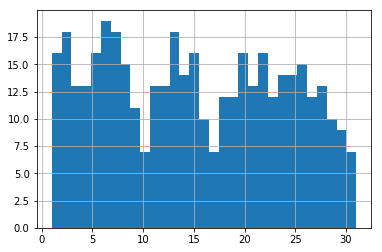

In [125]:
# Create Day column and plot histogram of invoice frequency by day of month
def get_year(row):
    dtime = datetime.datetime.strptime(row, '%Y-%m-%d %X')
    return dtime.year

tmp['year'] = tmp['InvoiceDate'].apply(get_year)
tmp['day'].hist(bins = 31)